# Multi step join of monthly Sentinel-2 data to points of interest

## 1. Setup


This notebook requires the following packages:

In [ ]:
import geopandas as gpd
import geoengine as ge

First, connect to the Geo Engine instance:

In [2]:
ge.initialize("http://localhost:3030/api", credentials=("admin@localhost", "admin1234"))

In [3]:
session = ge.get_session()
user_id = session.user_id
session

Server:              http://localhost:3030/api
User Id:             d5328854-6190-4af9-ad69-4e74b0961ac9
Session Id:          0c7cd3ef-40bb-439f-a4b3-13049d1578e6
Session valid until: 2023-04-08T19:25:16.699Z

## 2. Download Sentinel-2 data and store it in the Geo Engine

Since the Sentinel-2 data is stored in the cloud (AWS S3), we create a workflow to store it as a local dataset. While this is not necessary, it allows us to use the data in the Geo Engine without the need to download it again.

To track how much work is done, get the used quota:

In [4]:
used_quota_start = ge.get_quota(user_id)['used']
used_quota_start

0

Set the area of interest. It is defined as a bounding box in UTM 32 N (EPSG:32632).
It is located in NRW, Germany, and covers the area between Willingen, Lippstadt, and Werl.

In [5]:
bounds_array = [421395,  5681078, 476201, 5727833]
xmin = bounds_array[0]
ymin = bounds_array[1]
xmax = bounds_array[2]
ymax = bounds_array[3]

(xmin, ymin, xmax, ymax)

(421395, 5681078, 476201, 5727833)

Using the bounding box, a time interval and a resolution, we define the area of interest as a temporal raster space-time cube.

In [6]:
from datetime import datetime
time_start = datetime(2021, 1, 1)
time_end = datetime(2021, 12, 31)

study_area = ge.api.RasterQueryRectangle(
    spatialBounds=ge.SpatialPartition2D(xmin, ymin, xmax, ymax).to_api_dict(),
    timeInterval=ge.TimeInterval(time_start, time_end).to_api_dict(),
    spatialResolution=ge.SpatialResolution(10.0, 10.0).to_api_dict(),
)
study_area

{'spatialBounds': {'upperLeftCoordinate': {'x': 421395, 'y': 5727833},
  'lowerRightCoordinate': {'x': 476201, 'y': 5681078}},
 'timeInterval': {'start': '2021-01-01T00:00:00.000+00:00',
  'end': '2021-12-31T00:00:00.000+00:00'},
 'spatialResolution': {'x': 10.0, 'y': 10.0}}

For each band (B02, B03, B04, B08) as well as the scene mask (SCL), we create a workflow, that downloads the Sentinel-2 data for the area of interest and stores it as a new dataset.

In [7]:
status_download = {}

for b in ["B02", "B03", "B04", "B08", "SCL"]:
    print(b)
    sentinel2_band_workflow = ge.unstable.workflow_blueprints.sentinel2_band(b)
    sentinel2_band_workflow_id = ge.register_workflow(sentinel2_band_workflow.to_workflow_dict())
    sentinel2_band_workflow_dataset_task = sentinel2_band_workflow_id.save_as_dataset(study_area, f"sentinel2_nrw_crop_10m_{b}")
    sentinel2_band_workflow_dataset_task.wait_for_finish(print_status=False)
    print(sentinel2_band_workflow_dataset_task.get_status())
    status_download[b] = sentinel2_band_workflow_dataset_task.get_status()

status_download

{}

Check the quota used for downloading the bands:

In [8]:
used_quota_download = ge.get_quota(user_id)['used'] - used_quota_start
used_quota_download

0

## 3. Monthly, cloud-free aggregations of the Sentinel-2 bands & NDVI

For the training, we use the Sentinel-2 data of the bands 02, 03, 04, and 08. The scene classification layer (SCL) is used to filter out cloudy pixels for each band using an expression. The NDVI is calculated using an expression on band 4 and 8. 


Using the bands dataset_ids, we create a map from band name to Geo Engine "InternalDataId". The "InternalDataId" is used to reference the datasets in the workflow.

In [9]:
## IF you ran the workflow, you can get the ids from the status
band_data_map = { name: task_status.info['dataset'] for name, task_status in status_download.items() }
## IF you have the data already added, youn simply define the ids.
#band_data_map = {
#    'B02': 'a0630d89-fe7d-4087-98e4-aa496e681d50',
#    'B03': '1cfd9d51-6cbf-4490-9ce6-da224a6f5a83',
#    'B04': '6441f1f3-a9fb-4298-9161-eab91f0825e2',
#    'B08': '66479fef-4295-48f1-99bf-670f6b7ea540',
#    'SCL': '4d243f03-f59b-4298-80e9-0fb5aa94926e'
#    }

band_data_id_map = {name: 
    ge.api.InternalDataId(
        type="internal",
        datasetId=id) for name, id in band_data_map.items()
} 

band_data_id_map

{'B02': {'type': 'internal',
  'datasetId': 'a0630d89-fe7d-4087-98e4-aa496e681d50'},
 'B03': {'type': 'internal',
  'datasetId': '1cfd9d51-6cbf-4490-9ce6-da224a6f5a83'},
 'B04': {'type': 'internal',
  'datasetId': '6441f1f3-a9fb-4298-9161-eab91f0825e2'},
 'B08': {'type': 'internal',
  'datasetId': '66479fef-4295-48f1-99bf-670f6b7ea540'},
 'SCL': {'type': 'internal',
  'datasetId': '4d243f03-f59b-4298-80e9-0fb5aa94926e'}}

Now we create a workflow to aggregate each band to monthly means. We also create a monthly mean of the NDVI which is calculated using an expression on band 4 and 8. The resulting datasets are stored as new datasets.

In [10]:
status_agg = {}

for b in ["B02", "B03", "B04", "B08", "NDVI"]:
    print(b)
    sentinel2_band_workflow = ge.unstable.workflow_blueprints.s2_cloud_free_aggregated_band_custom_input(b, band_data_id_map, granularity="months", window_size=1, aggregation_type="mean")
    sentinel2_band_workflow_id = ge.register_workflow(sentinel2_band_workflow.to_workflow_dict())
    sentinel2_band_workflow_dataset_task = sentinel2_band_workflow_id.save_as_dataset(study_area, f"sentinel2_nrw_crop_10m_cf_monthly_{b}")
    sentinel2_band_workflow_dataset_task.wait_for_finish(print_status=False)
    print(sentinel2_band_workflow_dataset_task.get_status())
    status_agg[b] = sentinel2_band_workflow_dataset_task.get_status()

status_agg

B02
status=completed, time_started=2023-04-08 18:25:17.424000+00:00, info={'dataset': 'cf14cbe6-d747-48ca-abfe-bd9ea87618a4', 'upload': '26414c0d-e733-4fc8-98fa-7c5a99e91f5d'}, time_total=00:02:20
B03
status=completed, time_started=2023-04-08 18:27:42.743000+00:00, info={'dataset': 'a22225d9-1e96-4646-ad67-0efe41291361', 'upload': '83ee03c6-a7de-44b2-b967-1d2ca5634f76'}, time_total=00:02:22
B04
status=completed, time_started=2023-04-08 18:30:08.149000+00:00, info={'dataset': '47d9ee89-6d87-4228-824d-46c52c751db0', 'upload': '32ebe460-a501-4430-9555-bb0bfe074606'}, time_total=00:02:20
B08
status=completed, time_started=2023-04-08 18:32:33.585000+00:00, info={'dataset': '3db91688-19f2-4dca-9995-0f4097b3996a', 'upload': 'd1403fb3-969e-4171-9d48-053c42947dd3'}, time_total=00:02:19
NDVI
status=completed, time_started=2023-04-08 18:34:53.943000+00:00, info={'dataset': '2a36bca3-fbe9-4d24-854f-fa159b755bfb', 'upload': 'ebb5ec7b-fda1-4bfe-ae19-f2e73fa08c3a'}, time_total=00:03:20


{'B02': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 8, 18, 25, 17, 424000, tzinfo=datetime.timezone.utc),info = {'dataset': 'cf14cbe6-d747-48ca-abfe-bd9ea87618a4', 'upload': '26414c0d-e733-4fc8-98fa-7c5a99e91f5d'}, time_total = '00:02:20'),
 'B03': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 8, 18, 27, 42, 743000, tzinfo=datetime.timezone.utc),info = {'dataset': 'a22225d9-1e96-4646-ad67-0efe41291361', 'upload': '83ee03c6-a7de-44b2-b967-1d2ca5634f76'}, time_total = '00:02:22'),
 'B04': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 8, 18, 30, 8, 149000, tzinfo=datetime.timezone.utc),info = {'dataset': '47d9ee89-6d87-4228-824d-46c52c751db0', 'upload': '32ebe460-a501-4430-9555-bb0bfe074606'}, time_total = '00:02:20'),
 'B08': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 8, 18, 32, 33, 585000, tzinfo=datetime.timezone.utc),info = {'dataset': '3db91688-19f2-4dca-9995-0f409

Check the quota used for aggregating the bands (and calculating NDVI):

In [11]:
used_quota_agg = ge.get_quota(user_id)['used'] - used_quota_download
used_quota_agg

819360

## 4. Join the monthly Sentinel-2 data to the points of interest

This step combines the monthly Sentinel-2 data with the points of interest. The resulting dataset is then queried from the python client and stored as a pandas dataframe.

Again, we create a map from band name to Geo Engine "InternalDataId" for the aggregated bands. The "InternalDataId" is used to reference the datasets in the workflow.

In [12]:
## IF you ran the workflow, you can get the ids from the status
monthly_band_data_map = { name: task_status.info['dataset'] for name, task_status in status_agg.items() }
## IF you have the data already added, youn simply define the ids.
#monthly_band_data_map = {
#    'B02': '6aea7c86-05a6-45fc-ab3f-cd1020a83026',
#    'B03': '732bcff7-41b2-47a9-9a43-bb5d66feb8fd',
#    'B04': '209ffd4e-d750-4d88-a68a-5c36d739eb75',
#    'B08': 'ba469628-1c48-4172-af01-6bc460690600',
#    'NDVI': 'a5fbef96-0de3-498e-9e38-ddaf3a9fe47a'
#    }

monthly_band_data_id_map = {name: 
    ge.api.InternalDataId(
        type="internal",
        datasetId=id) for name, id in monthly_band_data_map.items()
} 


Upload the points to the Geo Engine:

In [13]:
points_df = gpd.read_file("group_sample_frac1_inspireId_use_utm32n.gpkg")
points_id = ge.upload_dataframe(points_df, "group_sample_frac1_inspireId")
points_id

829fbbf7-5445-4f31-8deb-720885f74bc8

Create a souce operator that provides the points to a workflow:

In [14]:
points_source_operator = ge.unstable.workflow_operators.OgrSource(str(points_id))
points_source_operator.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'OgrSource',
  'params': {'data': {'type': 'internal',
    'datasetId': '829fbbf7-5445-4f31-8deb-720885f74bc8'},
   'attributeProjection': None,
   'attributeFilters': None}}}

Now, we create a workflow that joins the monthly Sentinel-2 data to the points of interest for the queried time-interval. This uses the `RasterVectorJoin` operator.

In [15]:
points_with_s2_cloud_free = ge.unstable.workflow_operators.RasterVectorJoin(
    raster_sources=[ge.unstable.workflow_operators.GdalSource(x) for x in monthly_band_data_id_map.values() ],
    vector_source=points_source_operator,
    new_column_names=[x for x in monthly_band_data_id_map.keys()],
)

points_with_s2_cloud_free.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'RasterVectorJoin',
  'params': {'names': ['B02', 'B03', 'B04', 'B08', 'NDVI'],
   'temporalAggregation': 'none',
   'featureAggregation': 'mean'},
  'sources': {'vector': {'type': 'OgrSource',
    'params': {'data': {'type': 'internal',
      'datasetId': '829fbbf7-5445-4f31-8deb-720885f74bc8'},
     'attributeProjection': None,
     'attributeFilters': None}},
   'rasters': [{'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': 'cf14cbe6-d747-48ca-abfe-bd9ea87618a4'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': 'a22225d9-1e96-4646-ad67-0efe41291361'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': '47d9ee89-6d87-4228-824d-46c52c751db0'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': '3db91688-19f2-4dca-9995-0f4097b3996a'}}},
    {'type': 'GdalSource',
     'params': {

Since we want to train a Random-Forest on the monthly Sentinel-2 data, we need to attach all the months we are interested in to one point. The 'normal' way would be to query a time-interval and get points for each month with the respective values.
However, the RF expects the monthly values as columns. We can archive this using the `TimeShift` operator. The `TimeShift` operator shifts the query time interval by a given amount of time. It also shifts the returned time stamps of the data by the same amount of time but in the opposite direction. This way we can create a workflow that queries all the months we are interested in and attaches them as new columns to the points.



In [34]:
points_with_s2_cloud_free_shift = points_with_s2_cloud_free

for month_delta in range(-8,0):
        points_with_s2_cloud_free_shift = ge.unstable.workflow_operators.RasterVectorJoin(
        raster_sources=[ge.unstable.workflow_operators.TimeShift(granularity="months", value=month_delta, shift_type="relative", source=ge.unstable.workflow_operators.GdalSource(x)) for x in monthly_band_data_id_map.values() ],
        vector_source=points_with_s2_cloud_free_shift, #projected_points,
        new_column_names=[f'{x}_{month_delta}' for x in monthly_band_data_id_map.keys()],
    )


       
points_with_s2_cloud_free_shift.to_workflow_dict()


{'type': 'Vector',
 'operator': {'type': 'RasterVectorJoin',
  'params': {'names': ['B02_-1', 'B03_-1', 'B04_-1', 'B08_-1', 'NDVI_-1'],
   'temporalAggregation': 'none',
   'featureAggregation': 'mean'},
  'sources': {'vector': {'type': 'RasterVectorJoin',
    'params': {'names': ['B02_-2', 'B03_-2', 'B04_-2', 'B08_-2', 'NDVI_-2'],
     'temporalAggregation': 'none',
     'featureAggregation': 'mean'},
    'sources': {'vector': {'type': 'RasterVectorJoin',
      'params': {'names': ['B02_-3', 'B03_-3', 'B04_-3', 'B08_-3', 'NDVI_-3'],
       'temporalAggregation': 'none',
       'featureAggregation': 'mean'},
      'sources': {'vector': {'type': 'RasterVectorJoin',
        'params': {'names': ['B02_-4',
          'B03_-4',
          'B04_-4',
          'B08_-4',
          'NDVI_-4'],
         'temporalAggregation': 'none',
         'featureAggregation': 'mean'},
        'sources': {'vector': {'type': 'RasterVectorJoin',
          'params': {'names': ['B02_-5',
            'B03_-5',
    

Now we can register the workflow at the Geo Engine and execute it:

In [17]:
workflow = ge.register_workflow(points_with_s2_cloud_free_shift.to_workflow_dict())
workflow

071defa7-9947-5ba8-b858-697d5b66b414

Create datetime objects for the start and end of the time interval we use to query the final wrkflow:

In [18]:
start_dt = datetime(2021, 10, 1, 0, 0, 0)
end_dt = datetime(2021, 10, 1, 0, 0, 0)

start_dt, end_dt

(datetime.datetime(2021, 10, 1, 0, 0), datetime.datetime(2021, 10, 1, 0, 0))

Now, we query the workflow that attaches the Sentinel-2 data to the points and store the result as a pandas dataframe:

In [19]:
gp_res = await workflow.vector_stream_into_geopandas(
    ge.QueryRectangle(
        spatial_bounds=ge.BoundingBox2D(
            xmin=xmin,
            ymin=ymin,
            xmax=xmax,
            ymax=ymax,
        ),
        time_interval=ge.TimeInterval(
            start=start_dt,
            end=end_dt,
        ),
        resolution=ge.SpatialResolution(
            10.0,
            10.0,
        ),
        srs="EPSG:32632",
))

# gp_res.to_file("gp_res_10_frac1_monthly_use_utm32n_multi_steps_12months_shift.gpkg", driver="GPKG")
gp_res

,B02,NDVI_-7,NDVI_-5,B04_-8,B02_-1,NDVI_-3,B03_-1,B04_-6,B03_-2,ID,...,B08,USE_CODE,B03_-4,B03_-3,B04_-2,B04_-5,NDVI_-1,geometry,time_start,time_end
0,607.0,0.263462,0.222208,580.0,830.0,0.150360,1164.0,606.0,1048.0,0,...,1814.0,OE,1048.0,923.0,1380.0,1148.0,0.085486,MULTIPOINT (428690.027 5711938.189),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
1,719.0,0.321335,0.200790,693.0,880.0,0.102364,1174.0,523.0,1602.0,1,...,3555.0,GT,670.0,1279.0,1992.0,604.0,0.134015,MULTIPOINT (427819.337 5710040.545),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
2,683.0,0.333275,0.200724,730.0,960.0,0.137983,1330.0,414.0,1492.0,2,...,2369.0,GT,671.0,854.0,1883.0,NaN,0.108832,MULTIPOINT (427320.866 5710158.178),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
3,247.0,0.108798,0.185670,183.0,406.0,0.264426,545.0,391.0,386.0,3,...,1530.0,GL,465.0,440.0,238.0,378.0,0.397063,MULTIPOINT (431527.388 5693772.886),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
4,399.0,0.166214,0.216001,893.0,325.0,0.254812,541.0,501.0,604.0,4,...,3653.0,GL,699.0,726.0,418.0,523.0,0.406943,MULTIPOINT (431535.193 5693614.690),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,574.0,0.134030,0.241755,787.0,733.0,0.257517,1007.0,321.0,916.0,49419,...,2209.0,GT,552.0,649.0,1185.0,226.0,0.146780,MULTIPOINT (472357.075 5696612.529),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49420,193.0,0.087611,0.109226,802.0,206.0,0.319892,384.0,1257.0,488.0,49420,...,3954.0,GT,1264.0,598.0,395.0,1881.0,0.449148,MULTIPOINT (472016.875 5697690.039),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49421,511.0,0.106504,0.269948,939.0,799.0,0.213148,1121.0,723.0,854.0,49421,...,2379.0,GT,821.0,889.0,1062.0,483.0,0.200596,MULTIPOINT (471981.413 5696219.338),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49422,280.0,0.106873,0.149533,835.0,283.0,0.255698,465.0,998.0,858.0,49422,...,4083.0,AF,1237.0,777.0,813.0,1057.0,0.429673,MULTIPOINT (471704.064 5697043.769),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00


Check the quota used for querying the workflow:

In [20]:
used_quota_rvjoin = ge.get_quota(user_id)['used'] - used_quota_agg
used_quota_rvjoin

63257

## 5. Train a Random-Forest on the monthly Sentinel-2 data and the NRW crop data

Now we can train a Random-Forest on the monthly Sentinel-2 data and the NRW crop data. We use the `sklearn` package for this. But first, we need to prepare the data.

First, replace the nan values with 0. This is necessary since the RF does not support nan values.

In [21]:
import numpy as np
gp_train_1=gp_res.replace(np.nan, 0)#.groupby("USE_CODE").sample(n=300, replace=True)
gp_train_1

,B02,NDVI_-7,NDVI_-5,B04_-8,B02_-1,NDVI_-3,B03_-1,B04_-6,B03_-2,ID,...,B08,USE_CODE,B03_-4,B03_-3,B04_-2,B04_-5,NDVI_-1,geometry,time_start,time_end
0,607.0,0.263462,0.222208,580.0,830.0,0.150360,1164.0,606.0,1048.0,0,...,1814.0,OE,1048.0,923.0,1380.0,1148.0,0.085486,MULTIPOINT (428690.027 5711938.189),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
1,719.0,0.321335,0.200790,693.0,880.0,0.102364,1174.0,523.0,1602.0,1,...,3555.0,GT,670.0,1279.0,1992.0,604.0,0.134015,MULTIPOINT (427819.337 5710040.545),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
2,683.0,0.333275,0.200724,730.0,960.0,0.137983,1330.0,414.0,1492.0,2,...,2369.0,GT,671.0,854.0,1883.0,0.0,0.108832,MULTIPOINT (427320.866 5710158.178),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
3,247.0,0.108798,0.185670,183.0,406.0,0.264426,545.0,391.0,386.0,3,...,1530.0,GL,465.0,440.0,238.0,378.0,0.397063,MULTIPOINT (431527.388 5693772.886),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
4,399.0,0.166214,0.216001,893.0,325.0,0.254812,541.0,501.0,604.0,4,...,3653.0,GL,699.0,726.0,418.0,523.0,0.406943,MULTIPOINT (431535.193 5693614.690),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,574.0,0.134030,0.241755,787.0,733.0,0.257517,1007.0,321.0,916.0,49419,...,2209.0,GT,552.0,649.0,1185.0,226.0,0.146780,MULTIPOINT (472357.075 5696612.529),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49420,193.0,0.087611,0.109226,802.0,206.0,0.319892,384.0,1257.0,488.0,49420,...,3954.0,GT,1264.0,598.0,395.0,1881.0,0.449148,MULTIPOINT (472016.875 5697690.039),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49421,511.0,0.106504,0.269948,939.0,799.0,0.213148,1121.0,723.0,854.0,49421,...,2379.0,GT,821.0,889.0,1062.0,483.0,0.200596,MULTIPOINT (471981.413 5696219.338),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49422,280.0,0.106873,0.149533,835.0,283.0,0.255698,465.0,998.0,858.0,49422,...,4083.0,AF,1237.0,777.0,813.0,1057.0,0.429673,MULTIPOINT (471704.064 5697043.769),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00


While not nessessary, we make sure that the data feed to the RF is always in the same order.

In [22]:
train_variable_order = ['B02', 'B02_-1', 'B02_-2', 'B02_-3', 'B02_-4',  'B02_-5',  'B02_-6', 'B02_-7', 'B02_-8',
        'B03', 'B03_-1', 'B03_-2', 'B03_-3', 'B03_-4',  'B03_-5',  'B03_-6', 'B03_-7', 'B03_-8',
        'B04', 'B04_-1', 'B04_-2', 'B04_-3', 'B04_-4',  'B04_-5',  'B04_-6', 'B04_-7', 'B04_-8',
        'B08', 'B08_-1', 'B08_-2', 'B08_-3', 'B08_-4',  'B08_-5',  'B08_-6', 'B08_-7', 'B08_-8',
        'NDVI', 'NDVI_-1', 'NDVI_-2', 'NDVI_-3', 'NDVI_-4',  'NDVI_-5',  'NDVI_-6', 'NDVI_-7', 'NDVI_-8']

x_list = gp_train_1[train_variable_order].values

The labels are stored in the column `USE_CODE`. 

In [23]:
y_list = gp_train_1['USE_CODE'].replace(0, 'None')
y_list

0        OE
1        GT
2        GT
3        GL
4        GL
         ..
49419    GT
49420    GT
49421    GT
49422    AF
49423    GL
Name: USE_CODE, Length: 49424, dtype: object

First, we create a train-test split. We use 80% of the data for training and 20% for testing.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.2, random_state=31337, stratify=y_list)

Then, we train the RF on the training data:

In [25]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
X = X_train
Y = y_train
clf = RandomForestClassifier(random_state=1337, class_weight='balanced_subsample', n_estimators=300)
clf = clf.fit(X, Y)
clf

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       random_state=1337)

Print the accuracy of the RF on the test data:

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_score(y_test, clf.predict(X_test))

0.7725847243297926

Print the confusion matrix:

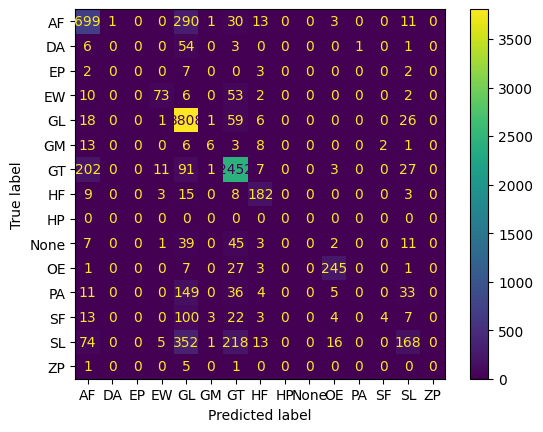

In [27]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## 6. Apply the trained Random-Forest to the monthly Sentinel-2 data

We can now create a workflow that generates the same monthly Sentinel-2 data as before, but this time want to apply the trained RF to the data. To do this, we query raster tiles from the Geo Engine and apply the RF to each tile. The result is a new raster dataset that contains the predicted crop class for each pixel.

Create workflows that produce the monthly Sentinel-2 data as raster tiles:

In [28]:


band_workflows_a = {b: ge.unstable.workflow_operators.GdalSource(x) for b, x in monthly_band_data_id_map.items()}

for month_delta in range(-8,0):
    for b in monthly_band_data_id_map.keys():
        w = band_workflows_a[b]
        band_workflows_a[f'{b}_{month_delta}'] = ge.unstable.workflow_operators.TimeShift(granularity="months", value=month_delta, shift_type="relative", source=w)

len(band_workflows_a)

band_workflows_b = {b: ge.register_workflow(band_workflows_a[b].to_workflow_dict()) for b in train_variable_order }
band_workflows_b



{'B02': 514aa881-87a7-56b0-a1d8-eddb1c5bfa22,
 'B02_-1': 0309a384-14ee-504e-8490-96d1cb04c47f,
 'B02_-2': f3341d6c-f735-5562-80a0-8df3d38aea02,
 'B02_-3': 52940eb6-cfed-546b-bf98-a7dfe274541a,
 'B02_-4': 30b40918-6daa-56c5-b35c-030175d63868,
 'B02_-5': aa55ae94-2201-5a05-89ff-3c99599cac32,
 'B02_-6': 8d765287-2164-542b-8c4b-c30fe6ef3f25,
 'B02_-7': 20b104a7-5dc4-598b-8dd6-01e13297c412,
 'B02_-8': 66a0af5d-18d7-51d0-95c2-11046f9be179,
 'B03': de501726-8d66-5cfd-a39c-481eac1aaf43,
 'B03_-1': dbffd060-d23d-5cc4-83c7-e53f46bd365f,
 'B03_-2': e122165a-42ea-57b8-980e-0b60b1ad2aa2,
 'B03_-3': 6f288fb6-252e-507b-934e-064ff67452bb,
 'B03_-4': dd8d75d1-a8d8-5861-8181-cfcced671a8a,
 'B03_-5': f95c3613-abe3-5ce6-b110-9d18026fbf6f,
 'B03_-6': 2c2d26d4-34da-5ca7-9ced-3535f8367b83,
 'B03_-7': caac0ccd-dc43-57f8-827c-266d9daa0888,
 'B03_-8': 893acef3-4b53-56e5-862c-729988ec0014,
 'B04': f4d7079b-594b-5450-b6e1-6e5860ddb576,
 'B04_-1': 1a9b56c7-e542-5a12-b497-03b86f2e2b45,
 'B04_-2': 09931d65-e137-5623

Now we specify the query rectangle we are interested in. It is a subeset of the area of interest defined in step 2.

In [29]:
start_dt = datetime(2021, 10, 15, 0, 0, 0)
end_dt = datetime(2021, 10, 15, 0, 0, 0)

box_size = 512

box_center_x = 0.5 * (xmin + xmax)
box_center_y = 0.5 * (ymin + ymax)

box_x_min = box_center_x - box_size / 2
box_x_max = box_x_min + box_size
box_y_min = box_center_y - box_size / 2
box_y_max = box_y_min + box_size

query_rect = ge.QueryRectangle(
        spatial_bounds=ge.BoundingBox2D(
            xmin=box_x_min,
            ymin=box_y_min,
            xmax=box_x_max,
            ymax=box_y_max,
        ),
        time_interval=ge.TimeInterval(
            start=start_dt,
            end=end_dt,
        ),
        resolution=ge.SpatialResolution(
            10.0,
            10.0,
        ),
        srs="EPSG:32632",
)

query_rect

QueryRectangle( 
    BoundingBox2D(xmin=448542.0, ymin=5704199.5, xmax=449054.0, ymax=5704711.5)
    TimeInterval(start=2021-10-15 00:00:00+00:00, end=2021-10-15 00:00:00+00:00)
    SpatialResolution(x=10.0, y=10.0)
    srs=EPSG:32632 
)

We also need a map from category to number. This is necessary since the RF produces class names and we want to store the result as a raster dataset.

In [30]:
code_id_map = {
    'None': 0,
    'AF': 1,
    'DA': 2,
    'EP': 3,
    'EW': 4,
    'GL': 5,
    'GM': 6,
    'GT': 7,
    'HF': 8,
    'HP': 9,
    'OE': 10,
    'PA': 11,
    'SF': 12,
    'SL': 13,
    'ZP': 14,    
}

Now we query all the workflows in parallel and zip the results together. The result is a list of tiles, where each tile contains the monthly Sentinel-2 data for one band and month.
For each tile (list) we apply the RF to the data and store the result as a new tile. The result is a list of tiles, where each tile contains the predicted crop class for one pixel.

In [31]:
from asyncstdlib.itertools import zip_longest
import xarray as xr

query_keys = list(band_workflows_b.keys())
queries = [
    w.raster_stream(query_rect) for w in band_workflows_b.values()
]

res_arrays = []

async for tile_stac in zip_longest(*queries):
    print(len(tile_stac))

    arr_stack = xr.concat(tile_stac, dim="band")
    
    res_array = xr.zeros_like(arr_stack.isel(band=0), dtype=np.uint8)

    for x in range(box_size):
        for y in range(box_size):
            
            rf_input = arr_stack[:, x, y].values
            np.nan_to_num(rf_input, copy=False, nan=0, posinf=None, neginf=None)

            pred_class = clf.predict([rf_input])[0]           
            res_array[x,y] = code_id_map[pred_class]

    res_arrays.append(res_array)

45


We can now print the result as a image:

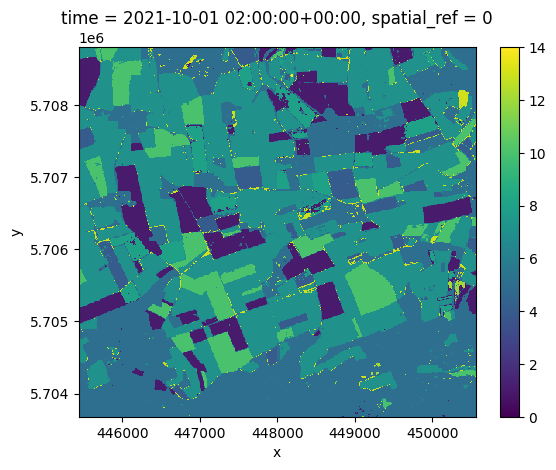

In [32]:
import matplotlib.pyplot as plt

for arr in res_arrays:
    plt.figure()
    arr.plot()


And finally, we can store the result as a new GeoTiFF file:

In [33]:
import rioxarray

for i, arr in enumerate(res_arrays):
    arr.rio.to_raster(
    f"arr_{i}.tif",
    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    windowed=True,  # rioxarray: read & write one window at a time
)